Data sudah stasioner (p-value <= 0.05).
Tuning ARIMA parameters...
Best ARIMA order: (3, 0, 0)
ARIMA Evaluation Metrics: {'MSE': 48089.13872171378, 'RMSE': 219.29235901351825, 'MAPE': 30.05654948053809, 'R2': -1.4878343230886975}
Tuning SARIMA parameters...
Best SARIMA order: (1, 0, 0, 1, 0, 1, 12)
SARIMA Evaluation Metrics: {'MSE': 119665.28363266763, 'RMSE': 345.9267026881094, 'MAPE': 49.96386150361556, 'R2': -5.1907409410322884}
Optimal Hybrid Alpha: 0.8
Hybrid Evaluation Metrics: {'MSE': 50315.934425028754, 'RMSE': 224.31213615190052, 'MAPE': 29.24877915381344, 'R2': -1.6030349469400034}


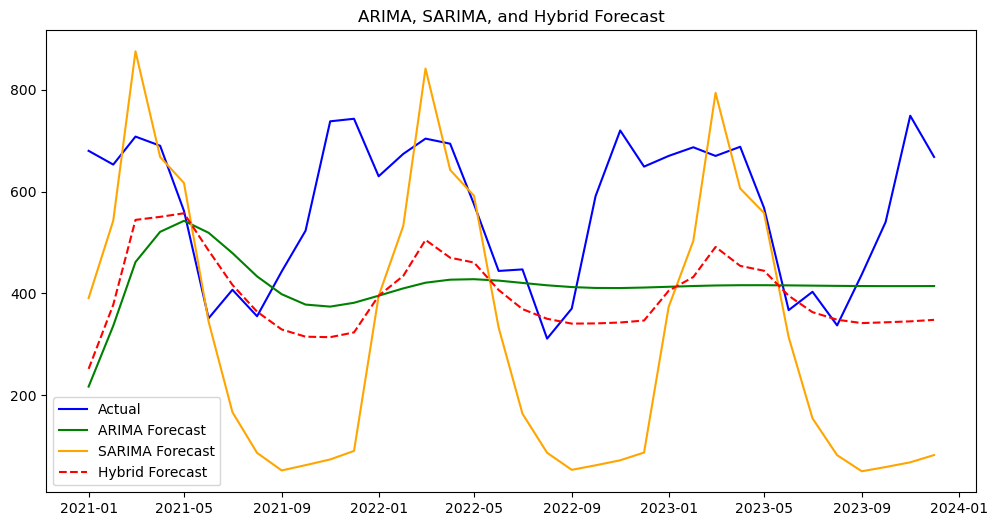

In [5]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Load datasets
train_path = r"C:\Users\ASUS\Downloads\ARIMA\data_kasus_ori.csv"
test_path = r"C:\Users\ASUS\Downloads\ARIMA\data_uji.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['periode'] = pd.to_datetime(train_df['periode'])
train_df.set_index('periode', inplace=True)

test_df['periode'] = pd.to_datetime(test_df['periode'])
test_df.set_index('periode', inplace=True)

train_time_series = train_df['jumlah_kasus']
test_time_series = test_df['jumlah_kasus']

# Define evaluation metrics
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}

# Perform differencing if needed
def check_stationarity(data):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data)
    if result[1] <= 0.05:
        print("Data sudah stasioner (p-value <= 0.05).")
        return data
    else:
        print("Data tidak stasioner, melakukan differencing.")
        return data.diff().dropna()

train_time_series = check_stationarity(train_time_series)

# Hyperparameter tuning for ARIMA
def tune_arima(train_data, p_range, d_range, q_range):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(train_data, order=(p, d, q)).fit()
            aic = model.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
        except:
            continue
    return best_cfg

print("Tuning ARIMA parameters...")
best_order = tune_arima(train_time_series, p_range=range(0, 5), d_range=[0], q_range=range(0, 5))
print(f"Best ARIMA order: {best_order}")

# Train ARIMA
arima_model = ARIMA(train_time_series, order=best_order).fit()
arima_forecast = arima_model.forecast(steps=len(test_time_series))
arima_metrics = evaluate_metrics(test_time_series.values, arima_forecast)
print("ARIMA Evaluation Metrics:", arima_metrics)

# Hyperparameter tuning for SARIMA
def tune_sarima(train_data, p_range, d_range, q_range, P_range, D_range, Q_range, m):
    best_score, best_cfg = float("inf"), None
    for p, d, q, P, D, Q in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range):
        try:
            model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit(disp=False)
            aic = model.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q, P, D, Q, m)
        except:
            continue
    return best_cfg

print("Tuning SARIMA parameters...")
best_sarima_order = tune_sarima(train_time_series, p_range=range(0, 5), d_range=[0], q_range=range(0, 5), 
                                P_range=range(0, 3), D_range=[0], Q_range=range(0, 3), m=12)
print(f"Best SARIMA order: {best_sarima_order}")

# Train SARIMA
sarima_model = SARIMAX(train_time_series, order=best_sarima_order[:3], seasonal_order=best_sarima_order[3:]).fit()
sarima_forecast = sarima_model.forecast(steps=len(test_time_series))
sarima_metrics = evaluate_metrics(test_time_series.values, sarima_forecast)
print("SARIMA Evaluation Metrics:", sarima_metrics)

# Hybrid Model: Combine ARIMA and SARIMA forecasts
def hybrid_forecast(arima_forecast, sarima_forecast, alpha=0.5):
    return alpha * arima_forecast + (1 - alpha) * sarima_forecast

best_mape = float("inf")
best_alpha = None
for alpha in np.linspace(0.1, 0.9, 9):
    hybrid_pred = hybrid_forecast(arima_forecast, sarima_forecast, alpha)
    mape = mean_absolute_percentage_error(test_time_series.values, hybrid_pred) * 100
    if mape < best_mape:
        best_mape = mape
        best_alpha = alpha

optimal_hybrid_forecast = hybrid_forecast(arima_forecast, sarima_forecast, best_alpha)
hybrid_metrics = evaluate_metrics(test_time_series.values, optimal_hybrid_forecast)
print(f"Optimal Hybrid Alpha: {best_alpha}")
print("Hybrid Evaluation Metrics:", hybrid_metrics)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_time_series.index, test_time_series, label="Actual", color="blue")
plt.plot(test_time_series.index, arima_forecast, label="ARIMA Forecast", color="green")
plt.plot(test_time_series.index, sarima_forecast, label="SARIMA Forecast", color="orange")
plt.plot(test_time_series.index, optimal_hybrid_forecast, label="Hybrid Forecast", color="red", linestyle="--")
plt.legend()
plt.title("ARIMA, SARIMA, and Hybrid Forecast")
plt.show()
